In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sqlite3

In [ ]:
con = sqlite3.connect("../data/nba.sqlite")
games = pd.read_sql_query("SELECT * FROM game", con)
active_players = pd.read_sql_query("SELECT full_name FROM player WHERE is_active=TRUE", con)

games_recent_5yrs = pd.read_sql_query("""
	SELECT * FROM game 
	WHERE season_type NOT IN ('All Star', 'All-Star') 
	AND game_date BETWEEN '2019-01-01 00:00:00' AND '2023-12-31 23:59:59'
    ORDER BY game_date DESC
""", con)

QUESTION 1: Which teams in the past 5 years score consistently the highest in their games?

C:\Users\kingn\AppData\Local\Temp\ipykernel_10136\25578311.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='game_year', y='points', data=yearly_avg, palette='grey')


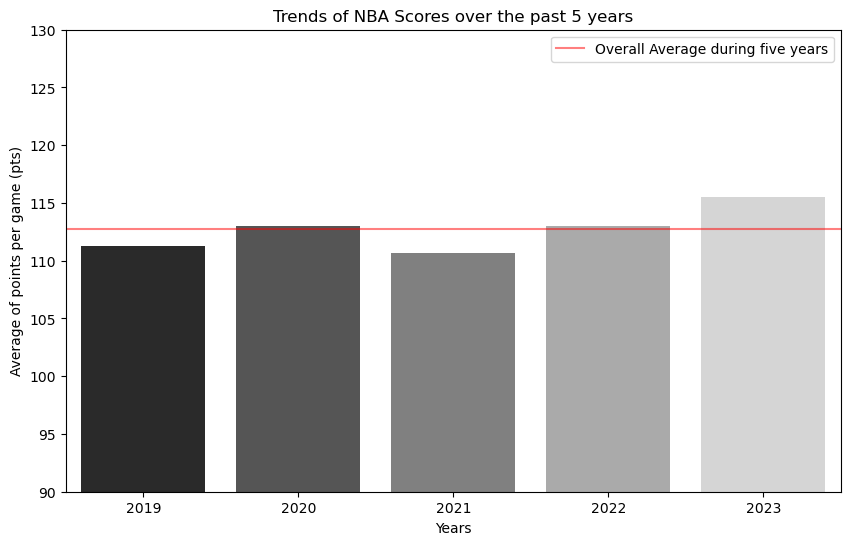

In [41]:
#INTRODUCTION: This question asks for teams who have scored the most in their games from the last five years. Teams who can effectively score high points consistently are likely to find
# potential success in the long term. 

#Visualization for Intro
regular_games = games_recent_5yrs[games_recent_5yrs['season_type']=='Regular Season']
games_recent_5yrs['game_year'] = pd.to_datetime(games_recent_5yrs['game_date']).dt.year

plt.figure(figsize=(10,6))
yearly_avg = regular_games.groupby('game_year').agg({
    'pts_home' : 'mean', 'pts_away' : 'mean'}).reset_index()
yearly_avg['points'] = (yearly_avg['pts_home'] + yearly_avg['pts_away'])/2
yearly_avg['game_year'] = yearly_avg['game_year'].astype(int)

sns.barplot(x='game_year', y='points', data=yearly_avg, palette='grey')

plt.axhline(y=yearly_avg['points'].mean(), color='r', linestyle='-', alpha=0.5, label='Overall Average during five years')
plt.ylim(90, 130)
plt.title('Trends of NBA Scores over the past 5 years')
plt.xlabel('Years')
plt.ylabel('Average of points per game (pts)')
plt.legend()
plt.show()


Teams with the highest average scores:
                                         mean        std  count  total_games
team_id    team_name                                                        
1610612749 Milwaukee Bucks         116.435716  12.726194  217.0          434
1610612762 Utah Jazz               114.124126  11.353901  196.5          393
1610612737 Atlanta Hawks           114.082051  12.425118  195.0          390
1610612750 Minnesota Timberwolves  114.046378  11.995903  184.0          368
1610612758 Sacramento Kings        113.760321  12.404773  186.5          373
1610612744 Golden State Warriors   113.553368  12.502250  207.5          415
1610612751 Brooklyn Nets           113.466575  12.269783  195.5          391
1610612740 New Orleans Pelicans    113.429579  11.357125  184.5          369
1610612763 Memphis Grizzlies       113.219401  12.564816  196.5          393
1610612756 Phoenix Suns            113.174049  11.591735  205.5          411


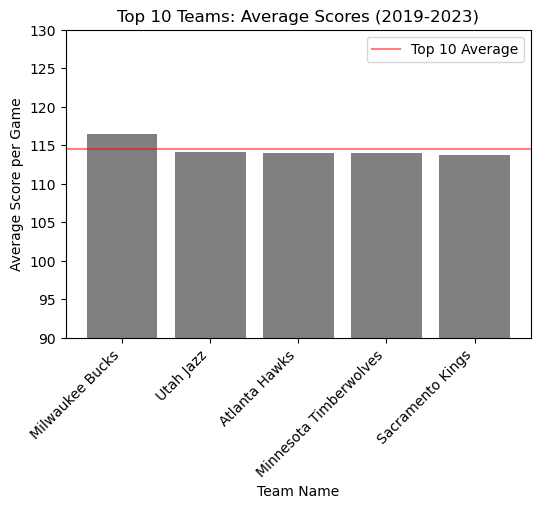

In [87]:
#RISING ACTION: To find these teams, we will pull info from all games from the past 5 years, and then calculate the stats for the home games and the away games.

# Calculate stats for home and away games
home_stats = games_recent_5yrs.groupby(['team_id_home', 'team_name_home'])['pts_home'].agg(['mean', 'std', 'count']).rename_axis(['team_id', 'team_name'])
away_stats = games_recent_5yrs.groupby(['team_id_away', 'team_name_away'])['pts_away'].agg(['mean', 'std', 'count']).rename_axis(['team_id', 'team_name'])

# Combine and aggregate stats
combined_stats = pd.concat([home_stats, away_stats])
score_stats = combined_stats.groupby(['team_id', 'team_name']).mean()
score_stats['total_games'] = combined_stats.groupby(['team_id', 'team_name'])['count'].sum()
score_stats = score_stats[score_stats['total_games'] >= 100]

# Display top 15 teams with the highest averages
print("Teams with the highest average scores:")
print(score_stats.sort_values(by='mean', ascending=False).head(10))

# Visualization for top 10 teams scoring
top10_teams = score_stats.sort_values(by='mean', ascending=False).head(10).reset_index()

plt.figure(figsize=(6, 4))
plt.bar(top10_teams['team_name'], top10_teams['mean'], color='grey')
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Teams: Average Scores (2019-2023)')
plt.xlabel('Team Name')
plt.ylabel('Average Score per Game')
plt.ylim(90, 130)

# Add average line
plt.axhline(y=top10_teams['mean'].mean(), color='red', linestyle='-', alpha=0.5, label='Top 10 Average')
plt.legend()
plt.show()

Teams with the highest score variance:
                                         mean        std  count  total_games
team_id    team_name                                                        
1610612746 LA Clippers             112.948365  13.477699  204.0          408
1610612760 Oklahoma City Thunder   110.057584  12.906594  189.5          379
1610612766 Charlotte Hornets       109.504817  12.853108  180.0          360
1610612745 Houston Rockets         112.141951  12.746809  194.5          389
1610612764 Washington Wizards      112.950441  12.736753  184.5          369
1610612757 Portland Trail Blazers  112.676168  12.730539  197.5          395
1610612749 Milwaukee Bucks         116.435716  12.726194  217.0          434
1610612752 New York Knicks         107.797772  12.572913  187.5          375
1610612763 Memphis Grizzlies       113.219401  12.564816  196.5          393
1610612738 Boston Celtics          112.827172  12.507385  219.5          439
1610612744 Golden State Warriors   11

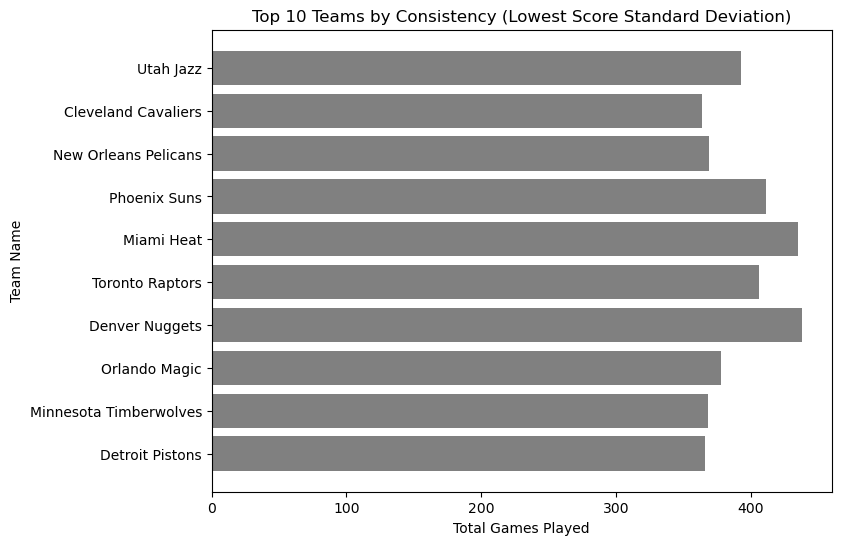

In [56]:
#CLIMAX: This leaves us with the 25 NBA teams with the highest average scores within the past 5 years. Every team included in this list has played at least 100 games total, this is to eliminate
# inactive or disbanded teams. This leaves us with these teams as our top 3 choices:

# 1) Milwaukee Bucks with 116.4 avg points and 434 total games played
# 2) Utah Jazz with 114.1 avg points and 393 total games played
# 3) Atlanta Hawks with 114 avg points and 390 total games played

# Display teams with the highest average score variability
print("Teams with the highest score variance:")
print(score_stats_all.nlargest(25, 'std'))

# Visualization: Top 10 most consistent teams (lowest std)
top10_consistent = score_stats_all.nsmallest(10, 'std').reset_index()

plt.figure(figsize=(8, 6))
top10_consistent = score_stats_all.nsmallest(10, 'std').reset_index()
top10_consistent = top10_consistent.sort_values(by='std')

plt.barh(top10_consistent['team_name'], top10_consistent['total_games'], color='gray')
plt.xlabel('Total Games Played')
plt.ylabel('Team Name')
plt.title('Top 10 Teams by Consistency (Lowest Score Standard Deviation)')
plt.gca().invert_yaxis()  # Ensures the most consistent team is at the top
plt.show()

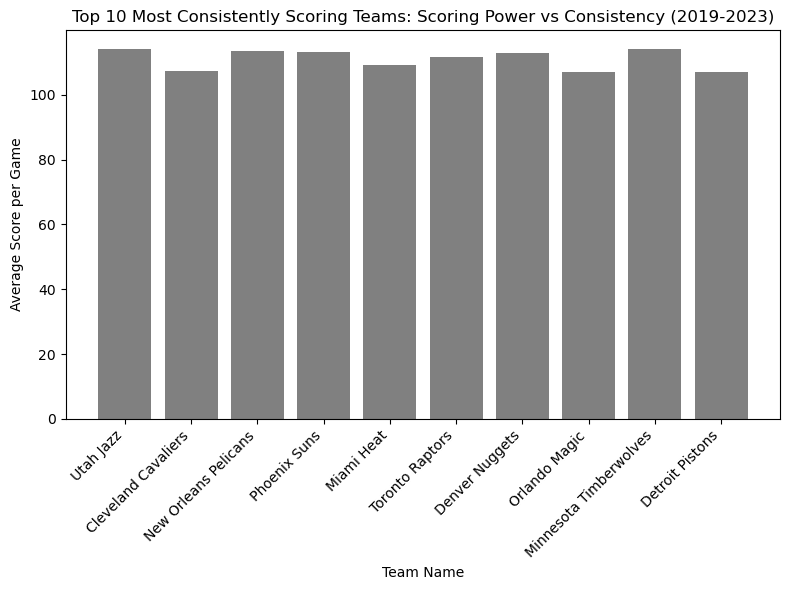

In [62]:
#FALLING ACTION: These teams have the highest score consistency in the past 5 years with at least 100 games played. The standout team is the Utah who has the highest level of consistency in their games. 
# Visualization: Top 10 most consistent teams (lowest std)
top10_consistent = score_stats_all.nsmallest(10, 'std').reset_index().sort_values(by='std')

plt.figure(figsize=(8, 6))
plt.bar(top10_consistent['team_name'], top10_consistent['mean'], color='grey')

plt.title('Top 10 Most Consistently Scoring Teams: Scoring Power vs Consistency (2019-2023)')
plt.xlabel('Team Name')
plt.ylabel('Average Score per Game')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#CONCLUSION: The most promising teams in terms of consistency look to be the Utah Jazz, the Cleveland Cavaliers, and the New Orleans Pelicans. 

QUESTION 2: WHICH TEAMS SCORED BELOW AVERAGE THE MOST CONSECUTIVELY? 

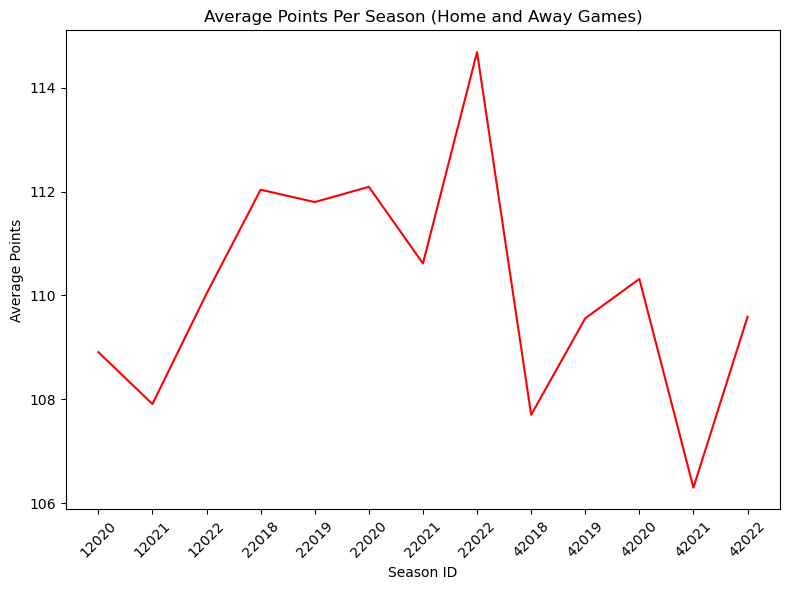

In [86]:
#INTRODUCTION: will first begin by calculate the average points per season, including home games and away games.

# Visualization: Average points per season, including home and away games
season_avg_points = all_games.groupby('season_id')['points'].mean().reset_index()

plt.figure(figsize=(8, 6))
plt.plot(season_avg_points['season_id'], season_avg_points['points'], color='red')

plt.title('Average Points Per Season (Home and Away Games)')
plt.xlabel('Season ID')
plt.ylabel('Average Points')
plt.xticks(season_avg_points['season_id'], rotation=45)
plt.tight_layout()
plt.show()



Teams with the Lowest Average Scores:
                   team_name      points
0  Ra'anana Maccabi Ra'anana   87.666667
1            Detroit Pistons  103.785668
2        Cleveland Cavaliers  104.168146
3              Orlando Magic  105.371162
4            New York Knicks  106.405505
5          Charlotte Hornets  106.416098
6             Indiana Pacers  107.782670
7                 Miami Heat  107.845605
8          San Antonio Spurs  109.226521
9         Los Angeles Lakers  109.257752


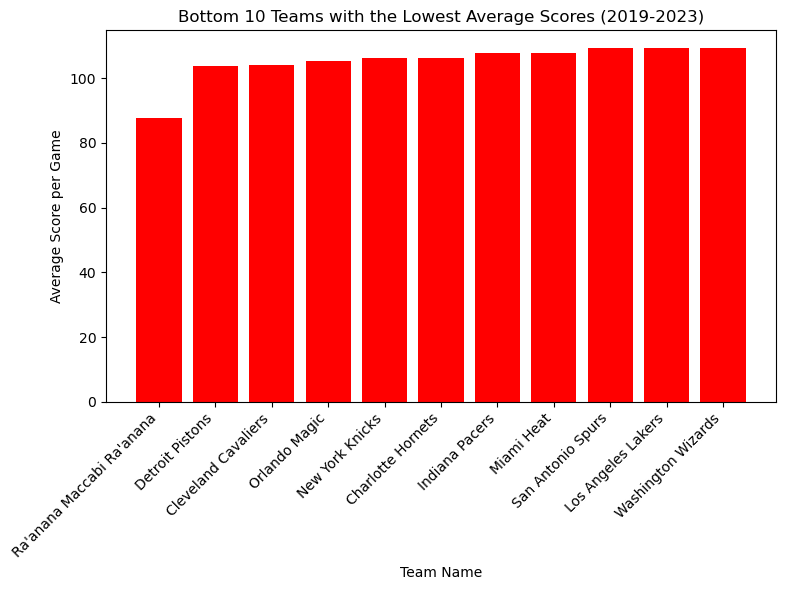

In [78]:
#RISING ACTION: We find the 10 teams that scored below this average.  

# Filter for teams with the lowest average scores across unique seasons
season_avg = pd.concat([games_recent_5yrs['pts_home'], games_recent_5yrs['pts_away']]).mean()

home_games = games_recent_5yrs[['season_id', 'team_id_home', 'team_name_home', 'pts_home']].rename(columns={
    'team_id_home': 'team_id',
    'team_name_home': 'team_name',
    'pts_home': 'points'
})
away_games = games_recent_5yrs[['season_id', 'team_id_away', 'team_name_away', 'pts_away']].rename(columns={
    'team_id_away': 'team_id',
    'team_name_away': 'team_name',
    'pts_away': 'points'
})

# Combine home and away games into a single dataset
all_games = pd.concat([home_games, away_games])

# Calculate average points per team per season
team_season_avg = all_games.groupby(['season_id', 'team_id', 'team_name'])['points'].mean().reset_index()

# Filter for unique teams with the lowest average scores
lowest_avg_teams = team_season_avg.groupby('team_name')['points'].mean().sort_values().reset_index()

print("Teams with the Lowest Average Scores:")
print(lowest_avg_teams.head(10))

# Visualization: Bottom 10 teams with the lowest average scores
bottom10_teams = lowest_avg_teams.head(11)

plt.figure(figsize=(8, 6))
plt.bar(bottom10_teams['team_name'], bottom10_teams['points'], color='red')

plt.title('Bottom 10 Teams with the Lowest Average Scores (2019-2023)')
plt.xlabel('Team Name')
plt.ylabel('Average Score per Game')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

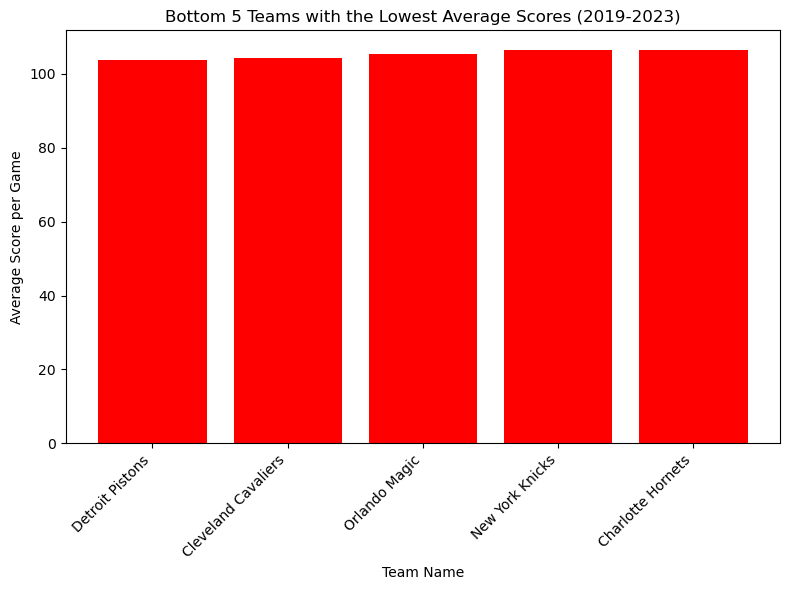

In [85]:
#CLIMAX: This leaves us with the 10 teams who have the lowest average scores. The Ra'anana Maccabi Ra'anana isn't apart of the NBA, so for the purposes of this question, we won't be including this team
# in the decision making process. The top 5 lowest scoring teams are as follows:

# 1) Detroit Pistons with 103.78 points
# 2) Cleveland Cavaliers with 104.16 points
# 3) Orlando Magic with 105.37 points
# 4) New York Knicks with 106.40 points
# 5) Charlotte Hornets with 106.41 points

# Visualization: Bottom 5 teams with the lowest average scores (excluding the first value)
bottom5_teams = lowest_avg_teams.iloc[1:6]

plt.figure(figsize=(8, 6))
plt.bar(bottom5_teams['team_name'], bottom5_teams['points'], color='red')

plt.title('Bottom 5 Teams with the Lowest Average Scores (2019-2023)')
plt.xlabel('Team Name')
plt.ylabel('Average Score per Game')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

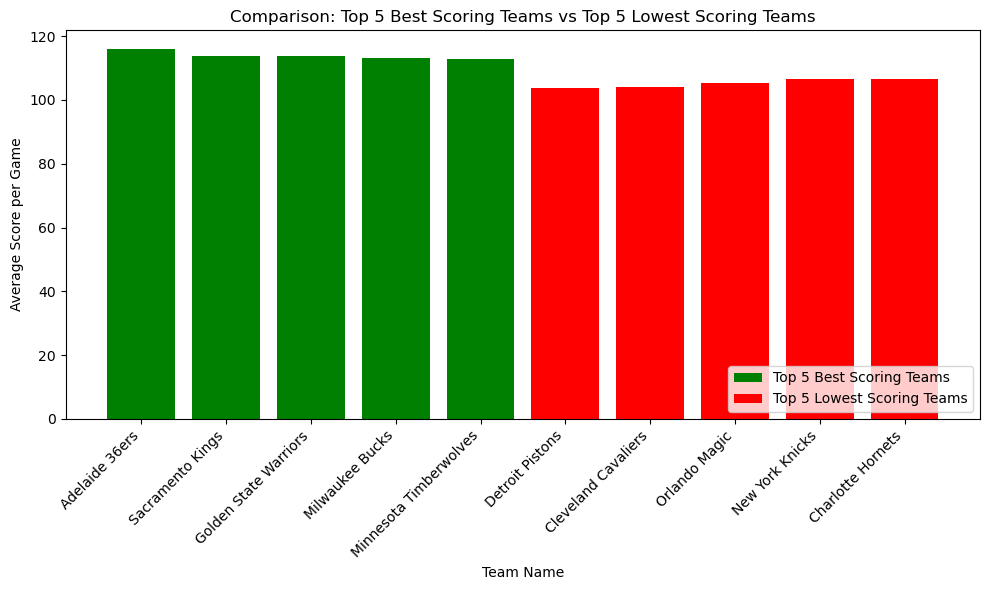

In [92]:
#FALLING ACTION: These 5 teams have the lowest average scores out of all the teams in the league. It can be inferred that these 5 teams have the weakest offensive capabilites in the league and should be
#avoided when making decisions regarding investment. It is important to keep in mind that because of their poor performances, these teams might be the cheapest to invest in as well. 

# Visualization: Top 5 best scoring teams vs Top 5 lowest scoring teams
top5_teams = lowest_avg_teams.tail(5).sort_values(by='points', ascending=False)
bottom5_teams = lowest_avg_teams.iloc[1:6]

plt.figure(figsize=(10, 6))
plt.bar(top5_teams['team_name'], top5_teams['points'], color='green', label='Top 5 Best Scoring Teams')
plt.bar(bottom5_teams['team_name'], bottom5_teams['points'], color='red', label='Top 5 Lowest Scoring Teams')

plt.title('Comparison: Top 5 Best Scoring Teams vs Top 5 Lowest Scoring Teams')
plt.xlabel('Team Name')
plt.ylabel('Average Score per Game')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


#CONCLUSION: These teams in red would require the most work when it comes to their offensive capabilites. Investing into these teams might be potentially risky as their success isn't guaranteed. 

Question 3: WHICH TEAM HAS HAD THE MOST CONSISTENT PLAYOFF APPEARANCES?

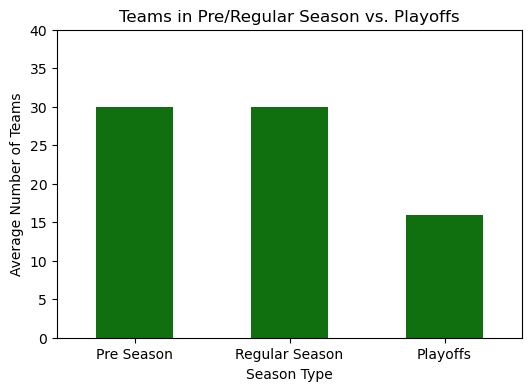

In [96]:
#INTRODUCTION: Playoffs are the gateway to the championship. This question asks for the teams who have most consistently made it to this stage of play. In other words, this question asks for
# the teams who are most likely to win a championship based on the frequency of their playoff appearances. Here's the kicker, not every team makes it to the playoffs.

unique_teams = games_recent_5yrs.groupby(['season_id', 'season_type'])['team_name_home'].nunique()
avg_unique_teams = unique_teams.groupby('season_type').mean()

season_order = ['Pre Season', 'Regular Season', 'Playoffs']
avg_unique_teams = avg_unique_teams.reindex(season_order)

plt.figure(figsize=(6, 4))
sns.barplot(x=avg_unique_teams.index, y=avg_unique_teams.values, color = 'green', width=0.5)
plt.title('Teams in Pre/Regular Season vs. Playoffs')
plt.xlabel('Season Type')
plt.ylabel('Average Number of Teams')
plt.ylim(0,40)

plt.show()


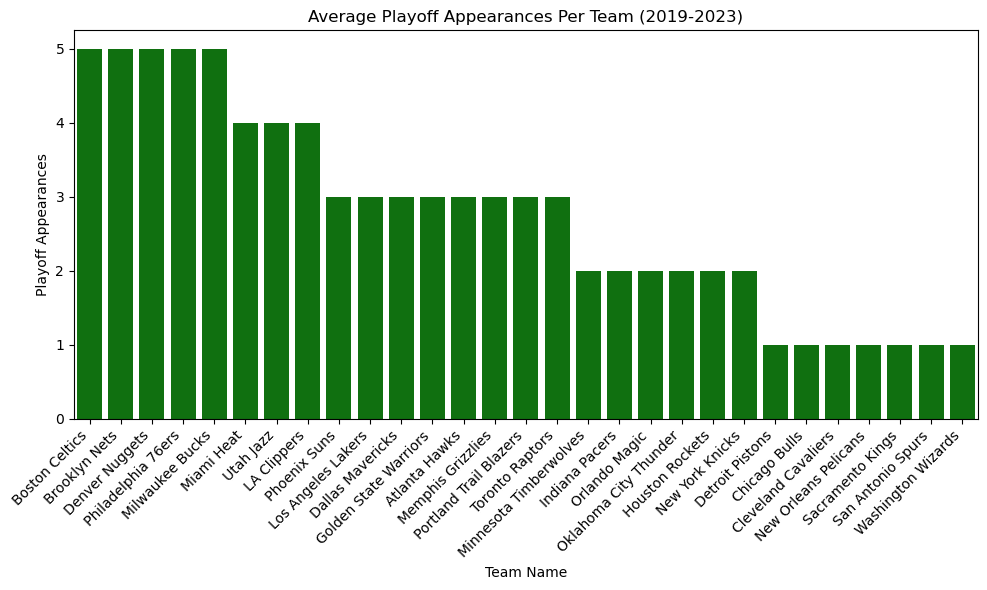

In [97]:
#RISING ACTION: We calculate the number of playoff appearances of each teams over the last 5 years. We then sort our created dataframe by teams who had the most consistent appearances. 

# Visualization: Average playoff appearances per team over the last 5 years
playoff_games = games_recent_5yrs[games_recent_5yrs['season_type'] == 'Playoffs']
playoff_appearances = playoff_games.groupby('team_name_home')['season_id'].nunique().reset_index()
playoff_appearances.columns = ['team_name', 'appearances']
playoff_appearances = playoff_appearances.sort_values(by='appearances', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='team_name', y='appearances', data=playoff_appearances, color='green')
plt.title('Average Playoff Appearances Per Team (2019-2023)')
plt.xlabel('Team Name')
plt.ylabel('Playoff Appearances')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

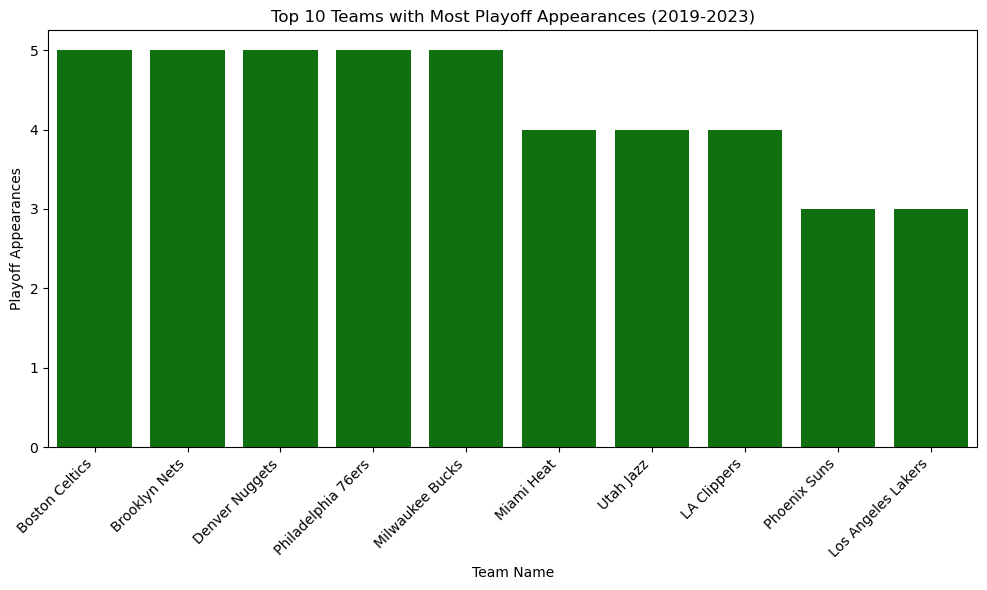

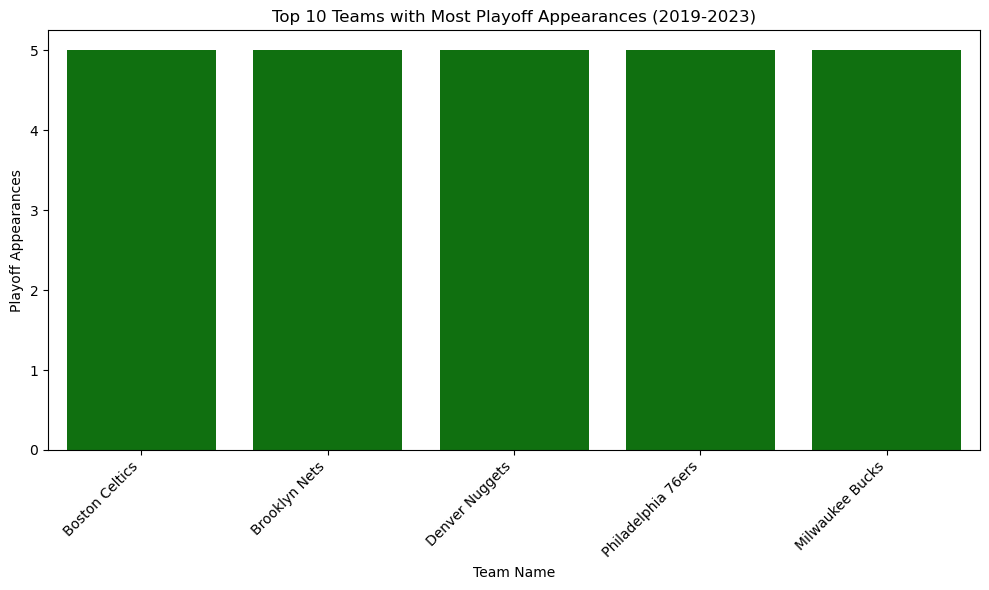

In [100]:
#CLIMAX: We then filter this down to only show the top 10 teams in terms of playoff appearances.

playoff_games = games_recent_5yrs[games_recent_5yrs['season_type'] == 'Playoffs']
playoff_appearances = playoff_games.groupby('team_name_home')['season_id'].nunique().reset_index()
playoff_appearances.columns = ['team_name', 'appearances']
playoff_appearances = playoff_appearances.sort_values(by='appearances', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='team_name', y='appearances', data=playoff_appearances, color='green')
plt.title('Top 10 Teams with Most Playoff Appearances (2019-2023)')
plt.xlabel('Team Name')
plt.ylabel('Playoff Appearances')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#FALLING ACTION: The Brooklyn Nets, Denver Nuggets, Philadelphia 76ers, and Milwaukee Bucks are the teams that made it to the playoffs most consistently in the past 5 years. 

playoff_games = games_recent_5yrs[games_recent_5yrs['season_type'] == 'Playoffs']
playoff_appearances = playoff_games.groupby('team_name_home')['season_id'].nunique().reset_index()
playoff_appearances.columns = ['team_name', 'appearances']
playoff_appearances = playoff_appearances.sort_values(by='appearances', ascending=False).head(5)

plt.figure(figsize=(10, 6))
sns.barplot(x='team_name', y='appearances', data=playoff_appearances, color='green')
plt.title('Top 10 Teams with Most Playoff Appearances (2019-2023)')
plt.xlabel('Team Name')
plt.ylabel('Playoff Appearances')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


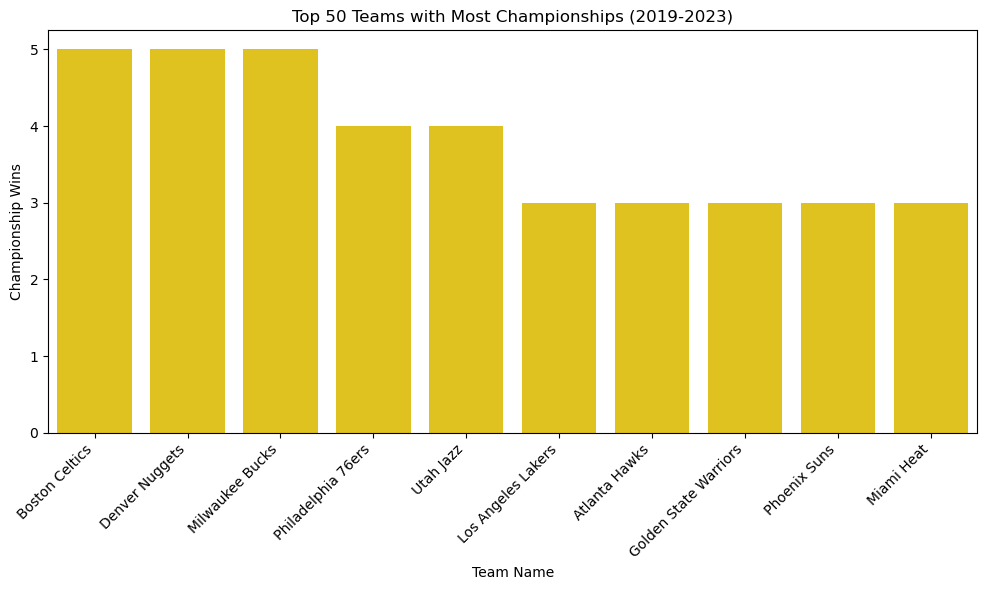

In [110]:
#CONCLUSION: Teams with more playoffs appearences means more opportunities for that team to win a championship. The Boston Celtics, Denver Nuggets, and Milwaukee Bucks prove this
# as they each have had 5 championship titles. 

championship_wins = playoff_games[playoff_games['wl_home'] == 'W'].groupby('team_name_home')['season_id'].nunique().reset_index()
championship_wins.columns = ['team_name', 'championships']
championship_wins = championship_wins.sort_values(by='championships', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='team_name', y='championships', data=championship_wins, color='gold')
plt.title('Top 10 Teams with Most Championships (2019-2023)')
plt.xlabel('Team Name')
plt.ylabel('Championship Wins')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#QUESTION 4: WHICH TEAMS HAVE IMPROVED THE MOST IN THE LAST 5 YEARS?


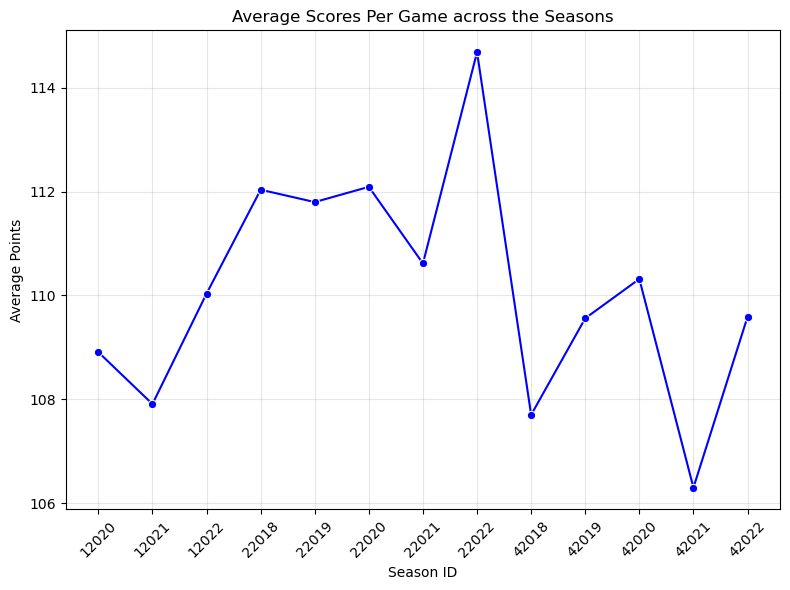

In [119]:
#INTRODUCTION: This question asks for the teams who have made the most improvement when it comes to their offensive capabilities in the last five years. These teams are important to keep an eye out for
# as they have the potential to be successful in future seasons. We start by creating an average of scores per game. 

plt.figure(figsize=(8, 6))
sns.lineplot(x='season_id', y='points', data=average_scores, marker='o', color='blue')
plt.title('Average Scores Per Game across the Seasons')
plt.xlabel('Season ID')
plt.ylabel('Average Points')
plt.xticks(average_scores['season_id'], rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Teams with the greatest improvement over the past five years:
                 team_name  total_improvement
19         New York Knicks          14.695726
25        Sacramento Kings          12.650000
14       Memphis Grizzlies          10.526330
0            Atlanta Hawks           9.028261
11          Indiana Pacers           8.326020
9    Golden State Warriors           7.655134
5      Cleveland Cavaliers           7.627350
13      Los Angeles Lakers           6.813824
20   Oklahoma City Thunder           6.298844
21           Orlando Magic           5.524613
7           Denver Nuggets           5.377463
4            Chicago Bulls           5.149422
1           Boston Celtics           4.875494
28               Utah Jazz           4.740310
22      Philadelphia 76ers           4.458629
6         Dallas Mavericks           4.343460
3        Charlotte Hornets           4.276423
17  Minnesota Timberwolves           4.053968
12             LA Clippers           2.143659
15              Mi

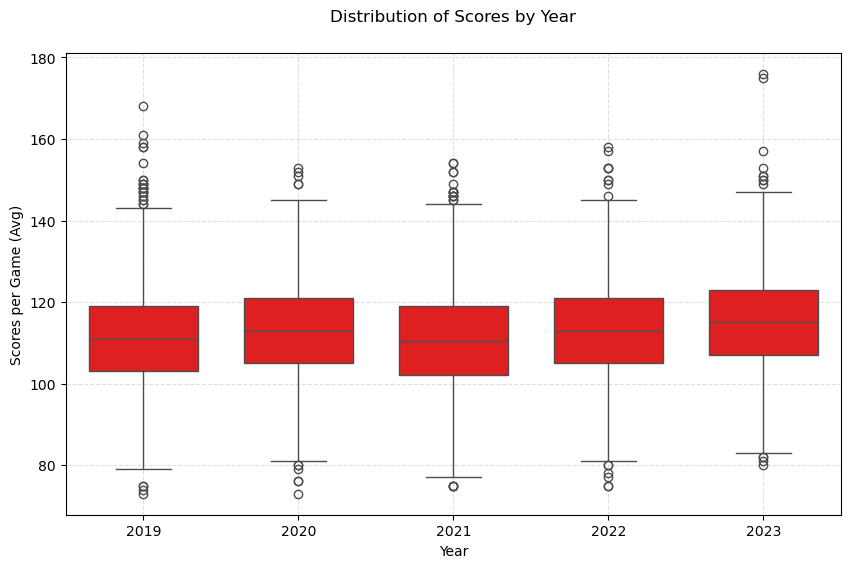

In [128]:
#RISING ACTION: We calculate scoring improvements made within the last 5 years by looking at average points scored and identifying the teams who have made the biggest strides.

# extract year from game_date
games_recent_5yrs['game_year'] = pd.to_datetime(games_recent_5yrs['game_date']).dt.year

# limit to regular season
regular_games = games_recent_5yrs[games_recent_5yrs['season_type']=='Regular Season']

# home and away game data 
reg_home_games = regular_games[['team_name_home', 'game_year', 'pts_home']].rename(
    columns={'team_name_home': 'team_name', 'pts_home': 'points'})
reg_away_games = regular_games[['team_name_away', 'game_year', 'pts_away']].rename(
    columns={'team_name_away': 'team_name', 'pts_away': 'points'})
reg_all_games = pd.concat([reg_home_games, reg_away_games])

# average points for each team by year
team_year_avg = reg_all_games.groupby(['team_name', 'game_year'])['points'].mean().reset_index()

# improvement
improvement_list = []

for team in team_year_avg['team_name'].unique():
    team_data = team_year_avg[team_year_avg['team_name'] == team].sort_values('game_year')
    
    total_improvement = team_data['points'].diff().sum() 
    
    improvement_list.append({
        'team_name': team, 
        'total_improvement': total_improvement
    })

team_improvement = pd.DataFrame(improvement_list)
team_improvement = team_improvement.sort_values(by='total_improvement', ascending=False)

print("Teams with the greatest improvement over the past five years:")
print(team_improvement.head(20))

# visualization for rising action

plt.figure(figsize=(10, 6))
sns.boxplot(data=reg_all_games, x='game_year', y='points', color = 'red', width=0.7)
plt.title('Distribution of Scores by Year', y=1.05)
plt.xlabel('Year')
plt.ylabel('Scores per Game (Avg)')
plt.grid(True, linestyle='--', alpha=0.4)

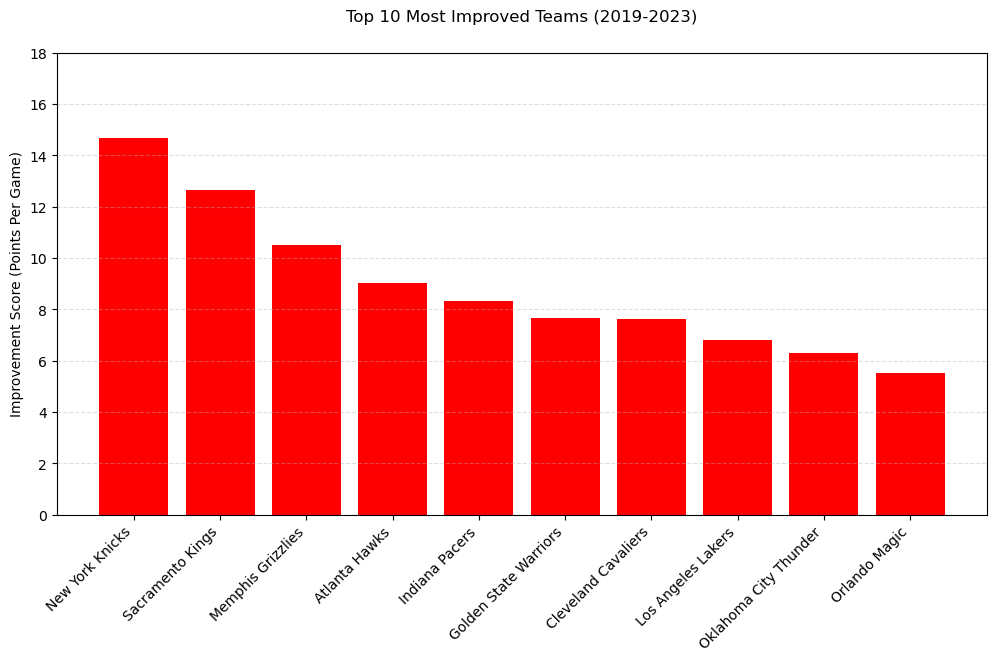

In [131]:
#CLIMAX: The three teams that have seen the most improvement over the past 5 years are the New York Knicks, the Sacremento Kings, and the Memphis Grizzlies. 
top_10 = team_improvement.sort_values(by='total_improvement', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(top_10['team_name'], top_10['total_improvement'], color = 'red')

plt.title('Top 10 Most Improved Teams (2019-2023)', y=1.05)
plt.ylabel('Improvement Score (Points Per Game)')
plt.xticks(rotation=45, ha='right')
plt.ylim(0,18)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.show()

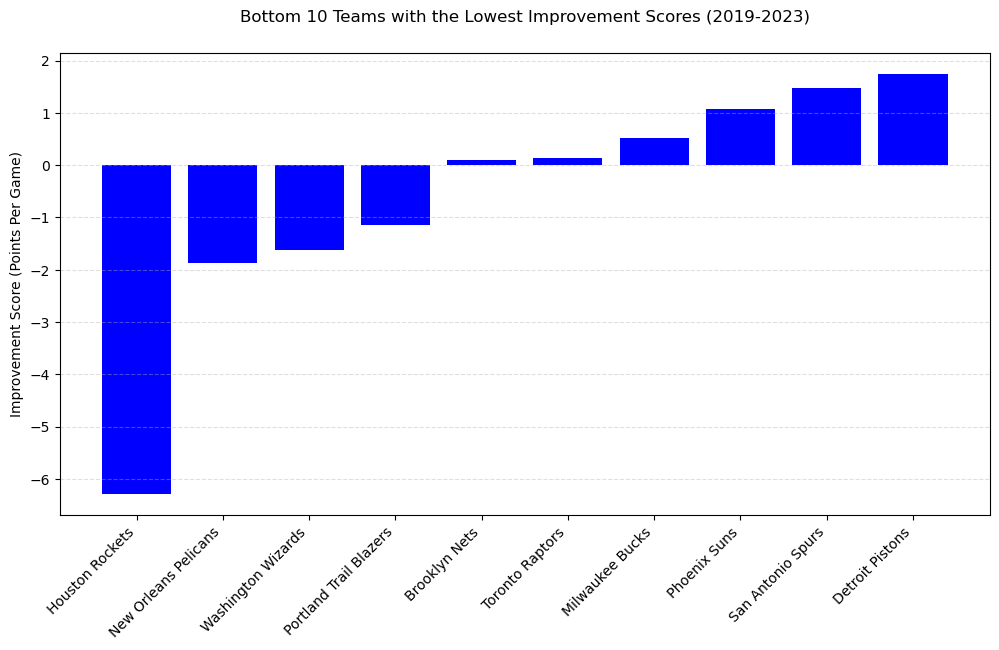

In [132]:
#FALLING ACTION: These teams, particularly the New York Knicks and the Sacremento Kings, are underdogs who are proving themselves to be rising stars to look out for. However we also need to look at 
# teams we should stay away from as well. 

# Sort to get the bottom 10 teams with the lowest improvement scores
bottom_10 = team_improvement.sort_values(by='total_improvement', ascending=True).head(10)

# Create a bar graph for the bottom 10 teams
plt.figure(figsize=(12, 6))
plt.bar(bottom_10['team_name'], bottom_10['total_improvement'], color='blue')

plt.title('Bottom 10 Teams with the Lowest Improvement Scores (2019-2023)', y=1.05)
plt.ylabel('Improvement Score (Points Per Game)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.show()

#CONCLUSION: While the Knicks and the Kings should be considered based on their high level of improvment, we should steer clear of teams like the Houston Rockets and the Brooklyn Nets
# these teams either have regressed when it comes to improvement (gotten worse) or have stagnated when it comes to improving.

QUESTION 5: WHICH TEAMS HAVE THE BEST DEFENSE? (BLOCKS/STEALS)

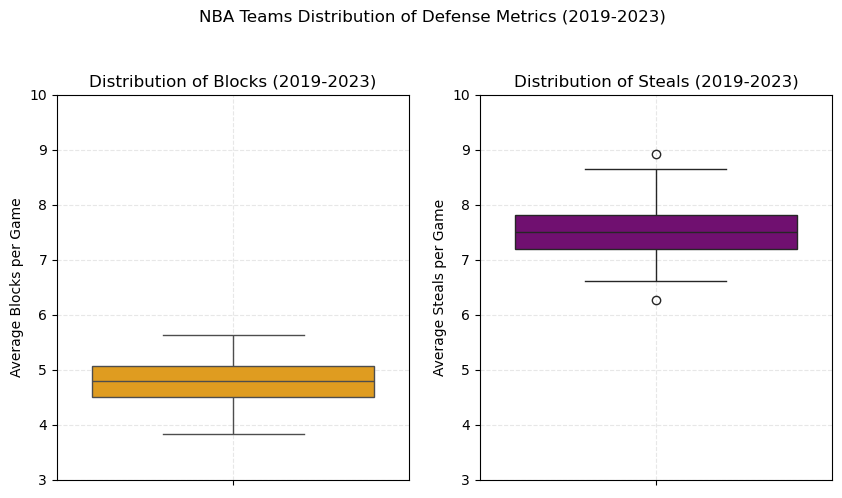

In [143]:
#INTRODUCTION: This question brings the importance of defensive stats into light. A good team must have a great offense but the best teams will have a 
# defense that is potentially greater. 

# Combine and process defense stats
defense = pd.concat([
    regular_games[['team_name_home', 'blk_home', 'stl_home', 'wl_home']].rename(
        columns={'team_name_home': 'team_name', 'blk_home': 'blocks', 'stl_home': 'steals', 'wl_home': 'win_loss'}),
    regular_games[['team_name_away', 'blk_away', 'stl_away', 'wl_away']].rename(
        columns={'team_name_away': 'team_name', 'blk_away': 'blocks', 'stl_away': 'steals', 'wl_away': 'win_loss'})
])

# Calculate stats
defense_stats = defense.groupby('team_name').agg(avg_blocks=('blocks', 'mean'), avg_steals=('steals', 'mean')).reset_index()
win_rates = defense.assign(win=(defense['win_loss'] == 'W')).groupby('team_name')['win'].mean().reset_index(name='win_rate')

# Merge and compute defense rating
defense_sorted = pd.merge(defense_stats, win_rates, on='team_name')
defense_sorted['defense_rating'] = defense_sorted['avg_blocks'] + defense_sorted['avg_steals']
defense_sorted = defense_sorted.sort_values(['defense_rating', 'win_rate'], ascending=[False, False])

# visualization for introduction - league-wide defense distribution

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

fig.suptitle('NBA Teams'' Distribution of Defense Metrics (2019-2023)', y=1.05)

# blocks
sns.boxplot(data=defense_analysis, y='avg_blocks', ax=ax1, color = 'orange' )
ax1.set_title('Distribution of Blocks (2019-2023)')
ax1.set_ylabel('Average Blocks per Game')
ax1.set_ylim(3,10)
plt.sca(ax1)
plt.grid(True, linestyle='--', alpha=0.3)

# steals
sns.boxplot(data=defense_analysis, y='avg_steals', ax=ax2, color = 'purple')
ax2.set_title('Distribution of Steals (2019-2023)')
ax2.set_ylabel('Average Steals per Game')
ax2.set_ylim(3,10)
plt.sca(ax2)
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()

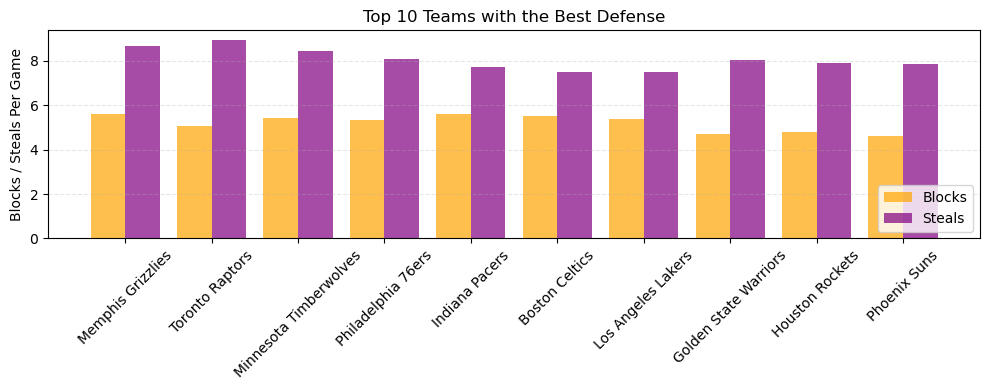

In [163]:
#RISING ACTION: By caluculating metrics like blocks and steals we will be able to rank the teams by defenseive effectiveness.
# Top 10 teams by defensive effectiveness
top_10_defense = defense_sorted.nlargest(10, 'defense_rating')

# Visualization: grouped bar chart
plt.figure(figsize=(10, 4))
x = range(len(top_10_defense))
width = 0.4

plt.bar(x, top_10_defense['avg_blocks'], width, label='Blocks', alpha=0.7, color = 'orange')
plt.bar([i + width for i in x], top_10_defense['avg_steals'], width, label='Steals', color='purple', alpha=0.7)

plt.title('Top 10 Teams with the Best Defense')
plt.ylabel('Blocks / Steals Per Game')
plt.xticks([i + width / 2 for i in x], top_10_defense['team_name'], rotation=45)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()



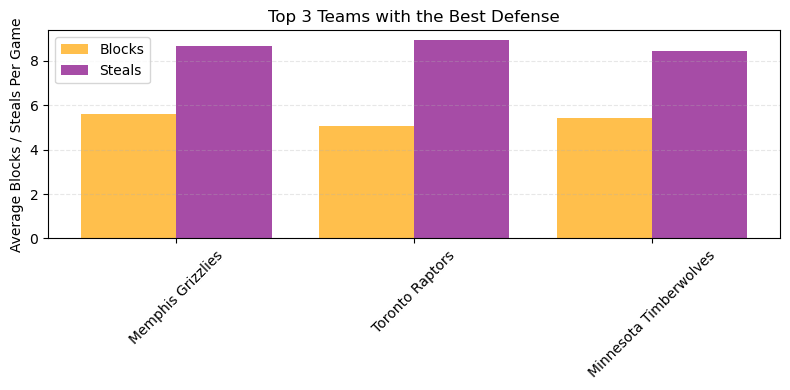

In [164]:
#CLIMAX: The top 3 teams with the highest defensive effectiveness in order are:
# 1) Memphis Grizzlies
# 2) Toronto Raptors
# 3) Minnesota Timberwolves

# Top 3 teams by defensive effectiveness
top_3_defense = defense_sorted.nlargest(3, 'defense_rating')

# Visualization: grouped bar chart
plt.figure(figsize=(8, 4))
x = range(len(top_3_defense))
width = 0.4

plt.bar(x, top_3_defense['avg_blocks'], width, label='Blocks', alpha=0.7, color = 'orange')
plt.bar([i + width for i in x], top_3_defense['avg_steals'], width, label='Steals', color='purple', alpha=0.7)

plt.title('Top 3 Teams with the Best Defense')
plt.ylabel('Average Blocks / Steals Per Game')
plt.xticks([i + width / 2 for i in x], top_3_defense['team_name'], rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


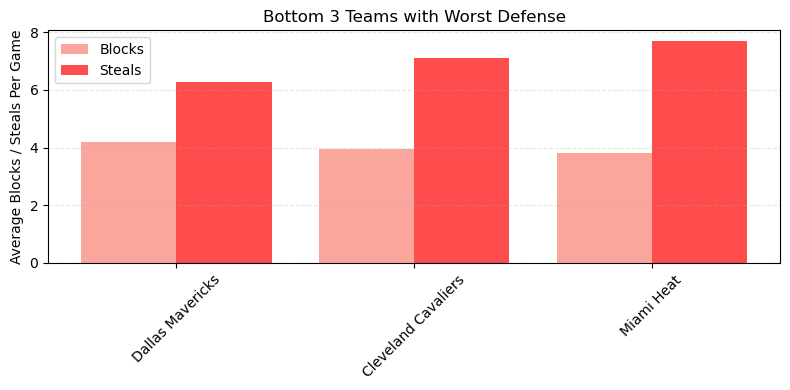

In [168]:
#FALLING ACTION: We found the top 3 teams with the best Defense, but like before to get the full picture we need to find the teams with the worst defense. These are the teams that
# are the most likely to let other teams score critical points over them, which can't be allowed in a critical scenario (like playoffs and championships.)

# Bottom 3 teams by defensive effectiveness
bottom_3_defense = defense_sorted.nsmallest(3, 'defense_rating')

# Visualization: grouped bar chart
plt.figure(figsize=(8, 4))
x = range(len(bottom_3_defense))
width = 0.4

plt.bar(x, bottom_3_defense['avg_blocks'], width, label='Blocks', alpha=0.7, color = 'salmon')
plt.bar([i + width for i in x], bottom_3_defense['avg_steals'], width, label='Steals', color='red', alpha=0.7)

plt.title('Bottom 3 Teams with Worst Defense')
plt.ylabel('Average Blocks / Steals Per Game')
plt.xticks([i + width / 2 for i in x], bottom_3_defense['team_name'], rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

#CONCLUSION: When looking at NBA statistics, it is easy to simply focus on teams who score the most. However, It is also extremely important to take defensive stats into consideration as well. 
# Well rounded teams have the potential to perform well in a number of different categories. 